In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v5auqsvf
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v5auqsvf
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179812 sha256=f0bbda3ec441281de77249a23bbe030a3f965e8211fbe94c41b499050fdd4e36
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8dxn6q6/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow

In [3]:
X = np.load('../content/images32_32.npy')
y = np.load('../content/labels32_32.npy')

In [4]:
tain_size=0.7
valid_size = 0.1
test_size = 0.2
valid_test_split = valid_size / test_size

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=1-tain_size, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=valid_test_split, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(7010, 32, 32, 3) (7010, 7)
(1503, 32, 32, 3) (1503, 7)
(1502, 32, 32, 3) (1502, 7)


In [5]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)      
  ]

In [6]:
histories = {}

In [7]:
img_height = 32
img_width = 32
channels = 3
img_shape = (img_height, img_width, channels)

In [8]:
# Create the base model with EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [10]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [12]:
Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )

In [13]:
prediction_layer = keras.layers.Dense(7, activation='softmax')

In [14]:
model = tf.keras.Sequential([
  base_model,
  Normalizator_layer,
  keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
  keras.layers.Dropout(rate=.45, seed=123),
  prediction_layer                           
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 6,910,094
Trainable params: 332,295
Non-trainable params: 6,577,799
________________________________________

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [17]:
loss0, accuracy0 = model.evaluate(X_val, y_val, steps = 20)

20/20 [==============================] - 8s 159ms/step - loss: 9.1648 - accuracy: 0.0340


In [18]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
220/220 [==============================] - 34s 102ms/step - loss: 6.7023 - accuracy: 0.6378 - val_loss: 5.2193 - val_accuracy: 0.6884
Epoch 2/40
220/220 [==============================] - 22s 101ms/step - loss: 4.2229 - accuracy: 0.6852 - val_loss: 3.4383 - val_accuracy: 0.6891
Epoch 3/40
220/220 [==============================] - 23s 105ms/step - loss: 2.9608 - accuracy: 0.6996 - val_loss: 2.5069 - val_accuracy: 0.6991
Epoch 4/40
220/220 [==============================] - 23s 103ms/step - loss: 2.2433 - accuracy: 0.7087 - val_loss: 1.9600 - val_accuracy: 0.7044
Epoch 5/40
220/220 [==============================] - 22s 98ms/step - loss: 1.8126 - accuracy: 0.7031 - val_loss: 1.6392 - val_accuracy: 0.7017
Epoch 6/40
220/220 [==============================] - 22s 98ms/step - loss: 1.5452 - accuracy: 0.7044 - val_loss: 1.4369 - val_accuracy: 0.7031
Epoch 7/40
220/220 [==============================] - 21s 97ms/step - loss: 1.3731 - accuracy: 0.7096 - val_loss: 1.3011 - val_accur

In [19]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

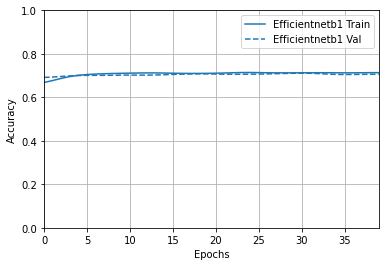

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 1])